<a href="https://colab.research.google.com/github/Ignacioelamo/LLMs4Phishing/blob/main/Limpieza_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza de datasets

## Descargas

In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=628bf971fcf27a41f9fced468bc82b7d650d7e5203640128ea1f9089e3b9aeef
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [2]:
!git lfs install
!git clone https://github.com/Ignacioelamo/LLMs4Phishing

Git LFS initialized.
Cloning into 'LLMs4Phishing'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 189 (from 1)
Receiving objects: 100% (190/190), 76.30 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Filtering content: 100% (7/7), 469.93 MiB | 21.05 MiB/s, done.


## Librerías

In [85]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import re

## Semilla

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

## Constantes

In [5]:
MAX_WORDS = 300
MIN_WORDS = 50

# Muestras de phising: 5000
SAMPLE_SIZE_TREC_PHIS = 1750
SAMPLE_SIZE_CEAS_PHIS = 880
SAMPLE_SIZE_ENRON_PHIS = 880
SAMPLE_SIZE_NIGERIAN = 630
SAMPLE_SIZE_NAZARIO = 450
SAMPLE_SIZE_SPAMASSASIN_PHIS = 270
SAMPLE_SIZE_LING_PHIS = 140


# Muestras de ham: 5000
SAMPLE_SIZE_TREC_HAM = 1724
SAMPLE_SIZE_CEAS_HAM = 862
SAMPLE_SIZE_ENRON_HAM = 862
SAMPLE_SIZE_SPAMASSASIN_HAM = 862
SAMPLE_SIZE_LING_HAM = 690

DATA_DIR = Path('./LLMs4Phishing/data/raw')
MERGED_DATASET = 'emails_unificados.csv'

DATA_CEAS = DATA_DIR / 'ceas_08.csv'
DATA_ENRON = DATA_DIR / 'enron.csv'
DATA_LING = DATA_DIR / 'ling.csv'
DATA_NAZARIO = DATA_DIR / 'nazario.csv'
DATA_NIGERIAN = DATA_DIR / 'nigerian_fraud.csv'
DATA_SPAMASSASSIN = DATA_DIR / 'spamassasin.csv'
DATA_TREC = DATA_DIR / 'trec_2007.csv'

## Funciones auxiliares

### plot_word_count_histogram

Esta función `plot_word_count_histogram()` genera un histograma de la distribución del número de palabras (`word_count`) en los mensajes, diferenciando visualmente las clases según el valor de la columna `label`.

**Parámetros:**
- `data`: DataFrame de entrada que debe contener las columnas `word_count` y `label`.
- `title`: Título del gráfico.
- `colors`: Tupla con los colores a usar para cada clase (por defecto: celeste para label 0 y coral claro para label 1).



In [80]:
def plot_word_count_histogram(data, title, colors=('skyblue', 'lightcoral')):
    plt.figure(figsize=(10, 6))
    for label, color in zip(data['label'].unique(), colors):
        subset = data[data['label'] == label]
        subset['word_count'].hist(bins=50, alpha=0.5, label=f'Label {label}', color=color)
    plt.title(title)
    plt.xlabel('Número de palabras')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()

### detect_language

Esta función `detect_language()` detecta el idioma de un texto utilizando la biblioteca `langdetect`.  
Si el texto no tiene suficiente contenido para determinar el idioma, retorna `'unknown'` en lugar de lanzar un error.

**Parámetros:**
- `text`: Cadena de texto (`str`) que representa el contenido del cual se desea detectar el idioma.



In [81]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

### clean_email_body

In [82]:
def clean_email_body(text):
    return re.sub(r'(Content-(Type|Transfer-Encoding|Disposition):.*?)(\n|\r|\r\n)', '', text, flags=re.IGNORECASE | re.DOTALL)

### strip_mime_headers

In [83]:
def strip_mime_headers(text):
    # Divide el correo por doble salto de línea y toma solo la parte del cuerpo
    parts = re.split(r'\n\s*\n', text, maxsplit=1)
    return parts[1] if len(parts) > 1 else text

## TREC

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [86]:
df_trec = (
    pd.read_csv(DATA_TREC, usecols=['subject', 'message', 'label'])
      .rename(columns={'message': 'body'})
      .assign(body=lambda df: df['body'].astype(str)
                         .apply(clean_email_body)
                         .apply(strip_mime_headers),
        word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

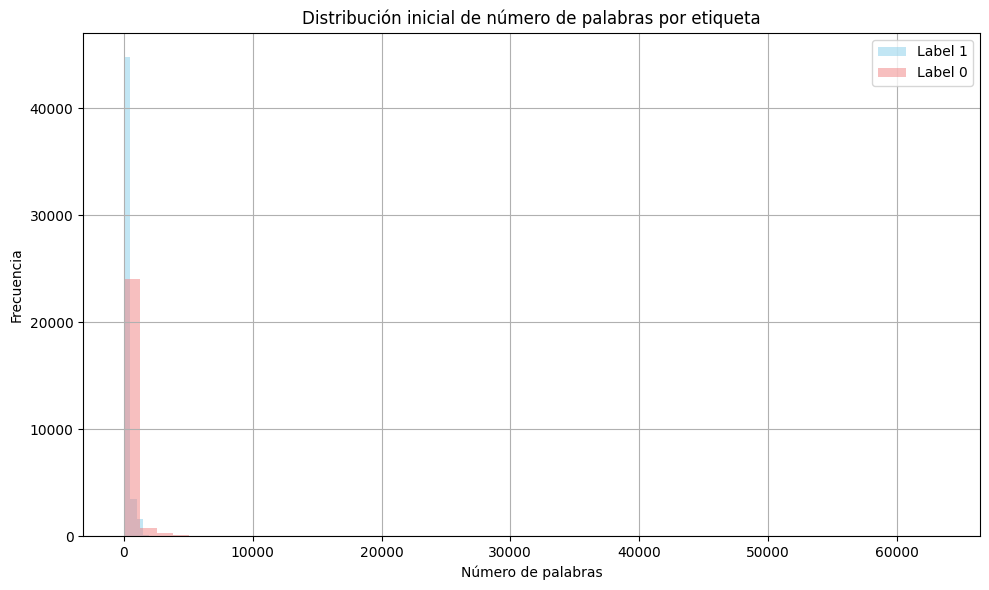

In [87]:
plot_word_count_histogram(df_trec,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


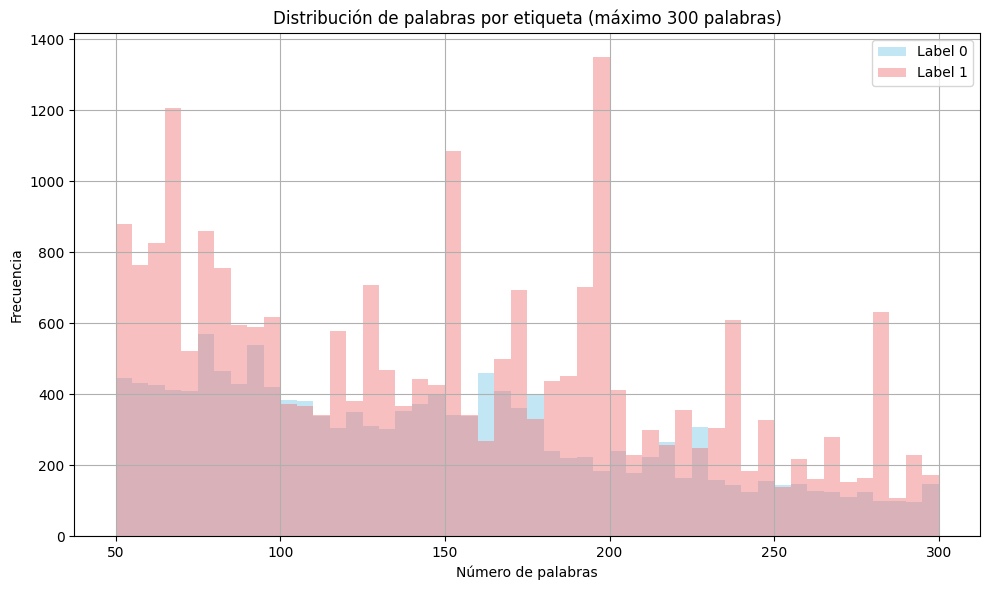

Número de instancias tras filtrado: 38119


In [88]:
df_trec_filtered = df_trec[
    (df_trec['word_count'] <= MAX_WORDS) &
    (MIN_WORDS <= df_trec['word_count'])
].copy()

df_trec_filtered['language'] = df_trec_filtered['body'].apply(detect_language)
df_trec_filtered = df_trec_filtered[df_trec_filtered['language'] == 'en']

plot_word_count_histogram(
    df_trec_filtered,
    f'Distribución de palabras por etiqueta (máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_trec_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


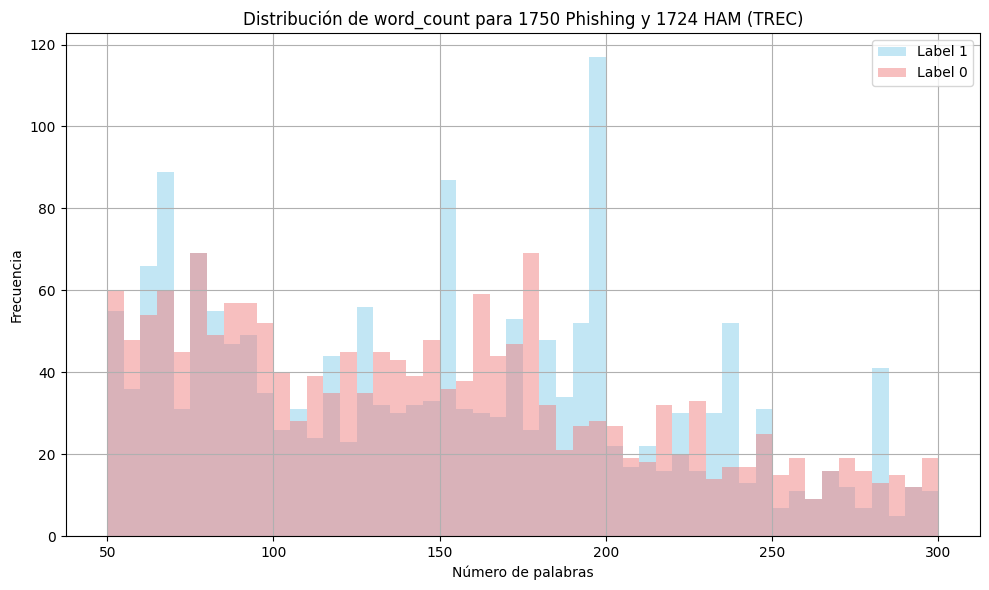

In [89]:
df_phishing_trec = df_trec_filtered[df_trec_filtered['label'] == 1].sample(n=SAMPLE_SIZE_TREC_PHIS, random_state=SEED)
df_ham_trec = df_trec_filtered[df_trec_filtered['label'] == 0].sample(n=SAMPLE_SIZE_TREC_HAM, random_state=SEED)

df_trec = pd.concat([df_phishing_trec, df_ham_trec])

plot_word_count_histogram(df_trec, f'Distribución de word_count para {SAMPLE_SIZE_TREC_PHIS} Phishing y {SAMPLE_SIZE_TREC_HAM} HAM (TREC)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [90]:
df_trec = df_trec.drop(columns=['word_count', 'language'])

print(f"{df_trec.shape=}")


print("\nDistribución final de etiquetas:")
print(df_trec['label'].value_counts())

df_trec.shape=(3474, 3)

Distribución final de etiquetas:
label
1    1750
0    1724
Name: count, dtype: int64


## CEAS 08

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [13]:
df_ceas = (
    pd.read_csv(DATA_CEAS, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

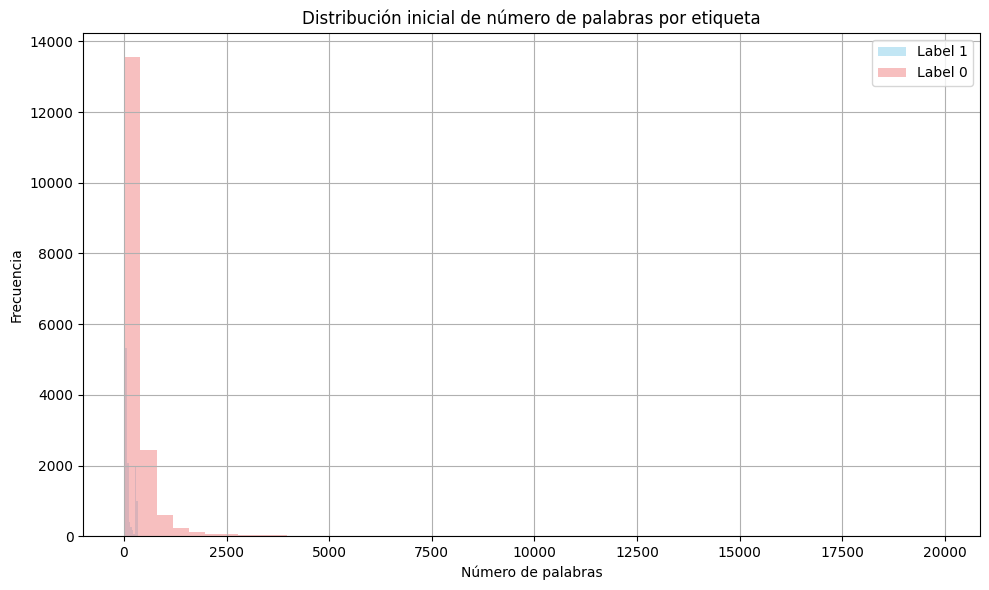

In [14]:
plot_word_count_histogram(df_ceas,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


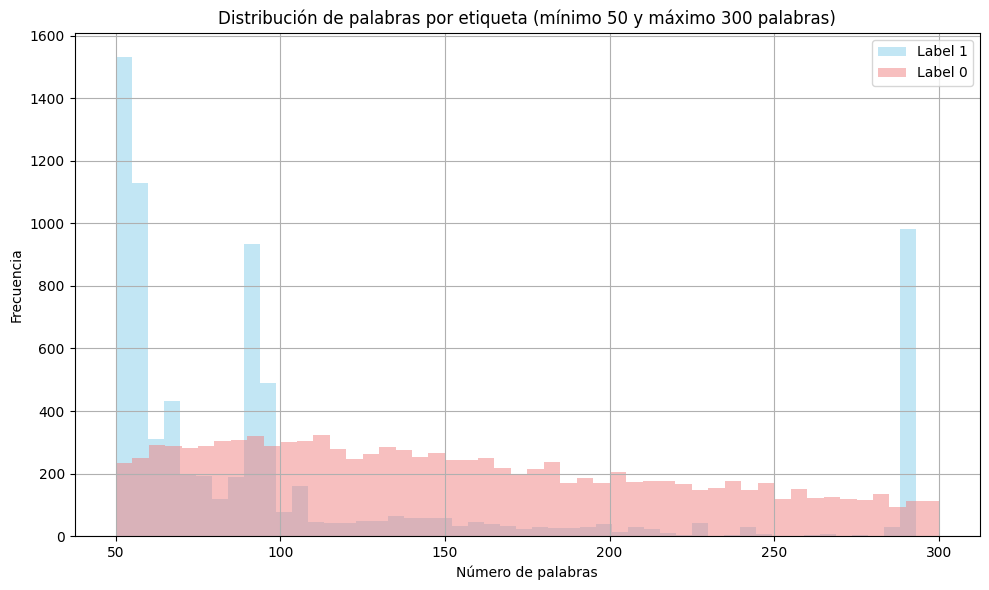

Número de instancias tras filtrado: 18424


In [15]:
df_ceas_filtered = df_ceas[
    (df_ceas['word_count'] <= MAX_WORDS) &
    (df_ceas['word_count'] >= MIN_WORDS)
].copy()

df_ceas_filtered['language'] = df_ceas_filtered['body'].apply(detect_language)
df_ceas_filtered = df_ceas_filtered[df_ceas_filtered['language'] == 'en']

plot_word_count_histogram(
    df_ceas_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_ceas_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


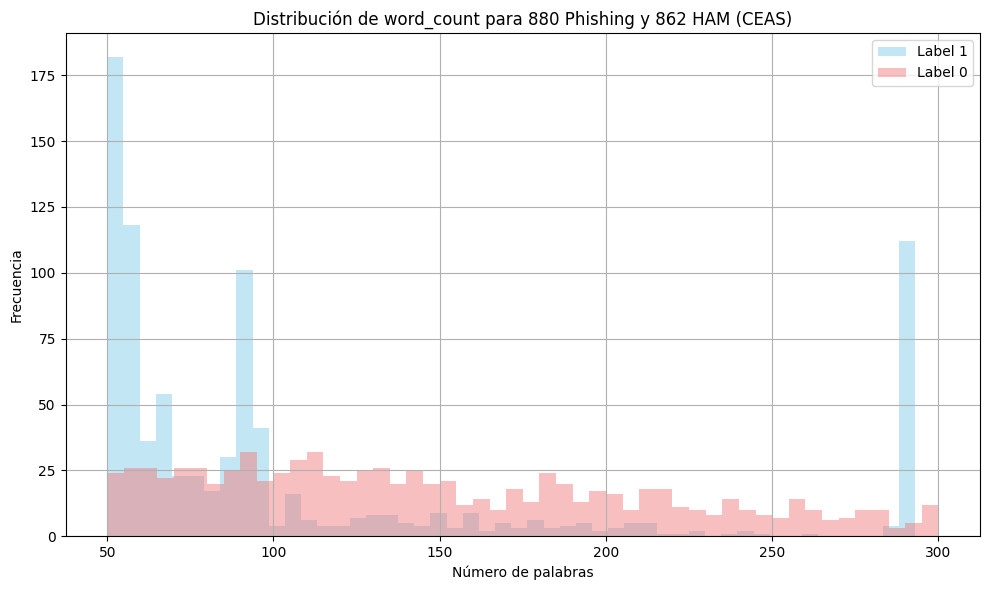

In [16]:
df_phishing_ceas = df_ceas_filtered[df_ceas_filtered['label'] == 1].sample(n=SAMPLE_SIZE_CEAS_PHIS, random_state=SEED)
df_ham_ceas = df_ceas_filtered[df_ceas_filtered['label'] == 0].sample(n=SAMPLE_SIZE_CEAS_HAM, random_state=SEED)

df_ceas = pd.concat([df_phishing_ceas, df_ham_ceas])

plot_word_count_histogram(df_ceas, f'Distribución de word_count para {SAMPLE_SIZE_CEAS_PHIS} Phishing y {SAMPLE_SIZE_CEAS_HAM} HAM (CEAS)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [17]:
df_ceas = df_ceas.drop(columns=['word_count', 'language'])

print(f"{df_ceas.shape=}")


print("\nDistribución final de etiquetas:")
print(df_ceas['label'].value_counts())

df_ceas.shape=(1742, 3)

Distribución final de etiquetas:
label
1    880
0    862
Name: count, dtype: int64


## ENRON

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [18]:
df_enron = (
    pd.read_csv(DATA_ENRON, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

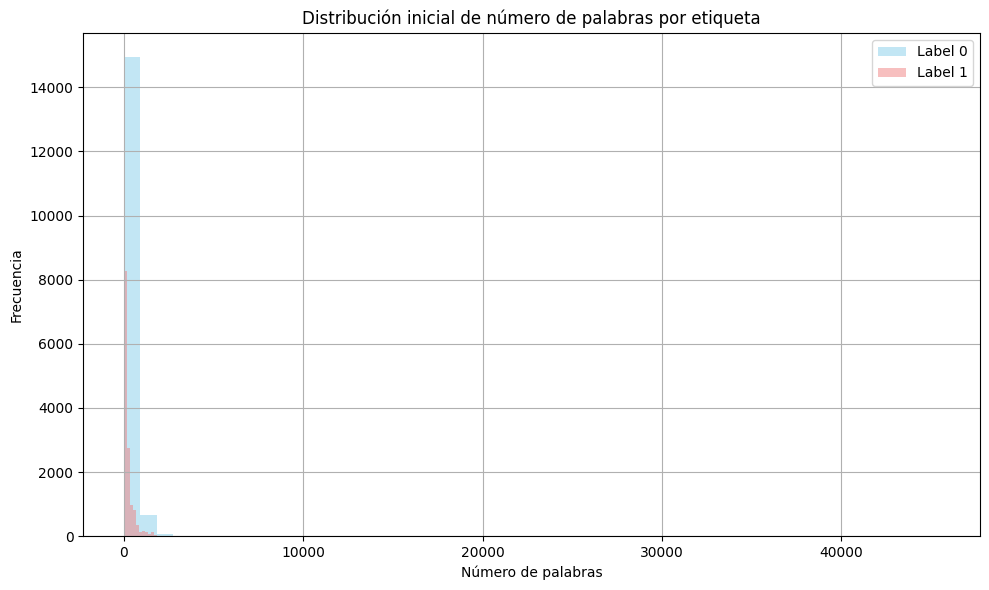

In [19]:
plot_word_count_histogram(df_enron,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


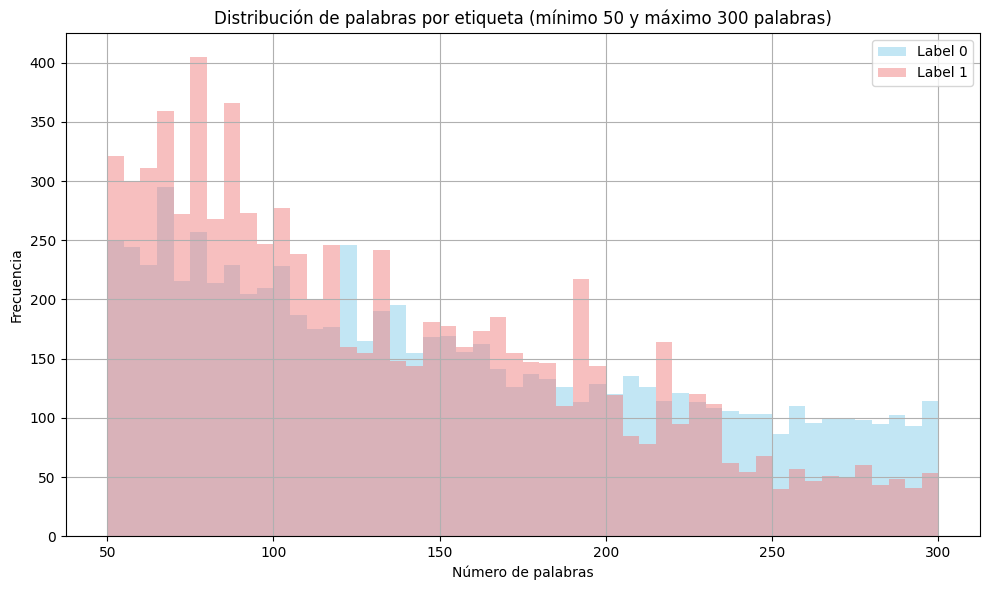

Número de instancias tras filtrado: 15942


In [20]:
df_enron_filtered = df_enron[
    (df_enron['word_count'] <= MAX_WORDS) &
    (df_enron['word_count'] >= MIN_WORDS)
].copy()

df_enron_filtered['language'] = df_enron_filtered['body'].apply(detect_language)
df_enron_filtered = df_enron_filtered[df_enron_filtered['language'] == 'en']

plot_word_count_histogram(
    df_enron_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_enron_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


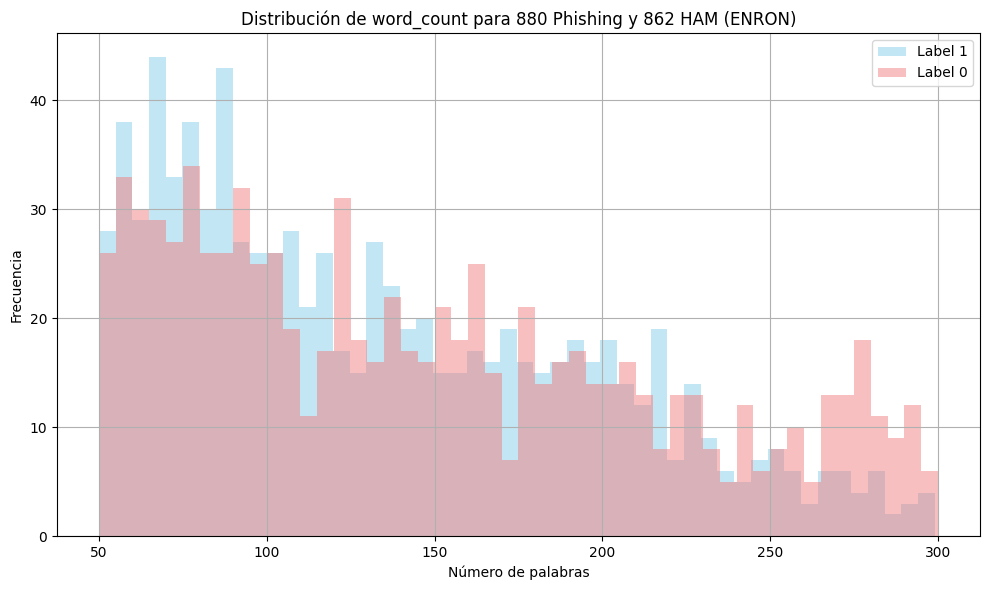

In [21]:
df_phishing_enron = df_enron_filtered[df_enron_filtered['label'] == 1].sample(n=SAMPLE_SIZE_ENRON_PHIS, random_state=SEED)
df_ham_enron = df_enron_filtered[df_enron_filtered['label'] == 0].sample(n=SAMPLE_SIZE_ENRON_HAM, random_state=SEED)

df_enron = pd.concat([df_phishing_enron, df_ham_enron])

plot_word_count_histogram(df_enron, f'Distribución de word_count para {SAMPLE_SIZE_ENRON_PHIS} Phishing y {SAMPLE_SIZE_ENRON_HAM} HAM (ENRON)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [22]:
df_enron = df_enron.drop(columns=['word_count', 'language'])

print(f"{df_enron.shape=}")


print("\nDistribución final de etiquetas:")
print(df_enron['label'].value_counts())

df_enron.shape=(1742, 3)

Distribución final de etiquetas:
label
1    880
0    862
Name: count, dtype: int64


## SPAMASSASIN

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [65]:
df_spamassasin = (
    pd.read_csv(DATA_SPAMASSASSIN, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

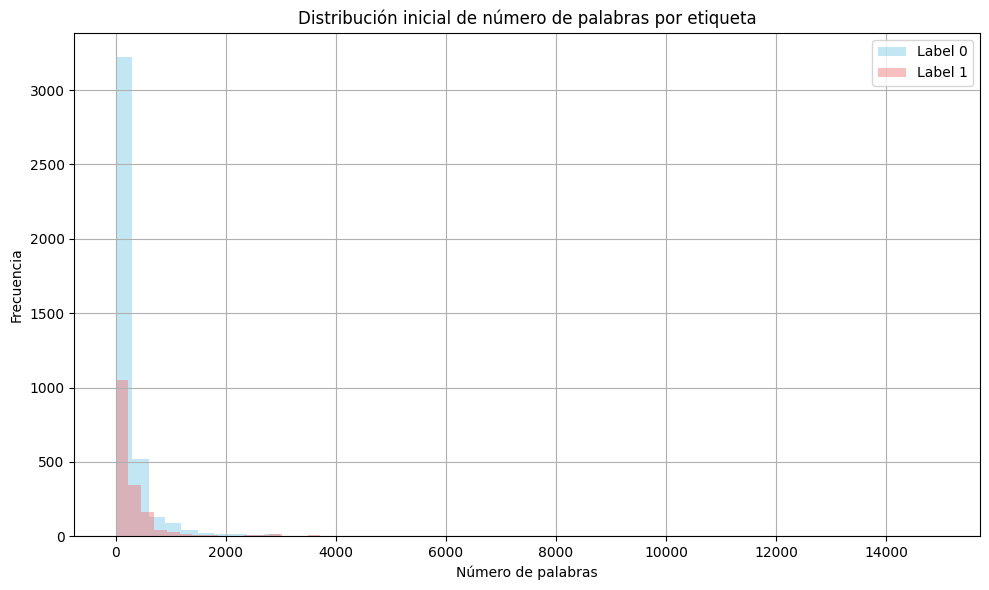

In [66]:
plot_word_count_histogram(df_spamassasin,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


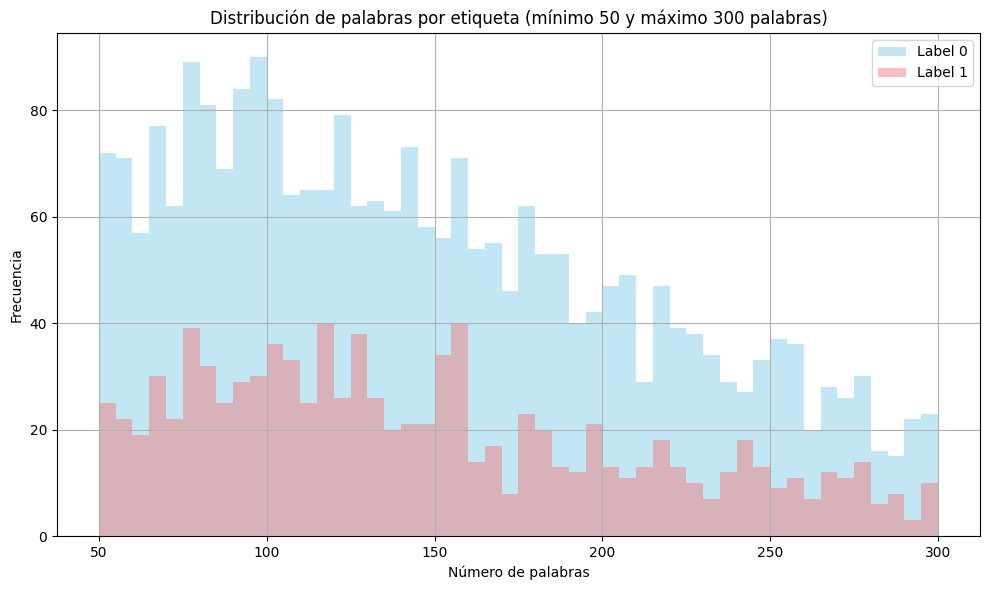

Número de instancias tras filtrado: 3561


In [67]:
df_spamassasin_filtered = df_spamassasin[
    (df_spamassasin['word_count'] <= MAX_WORDS) &
    (df_spamassasin['word_count'] >= MIN_WORDS)
].copy()

df_spamassasin_filtered['language'] = df_spamassasin_filtered['body'].apply(detect_language)
df_spamassasin_filtered = df_spamassasin_filtered[df_spamassasin_filtered['language'] == 'en']

plot_word_count_histogram(
    df_spamassasin_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_spamassasin_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


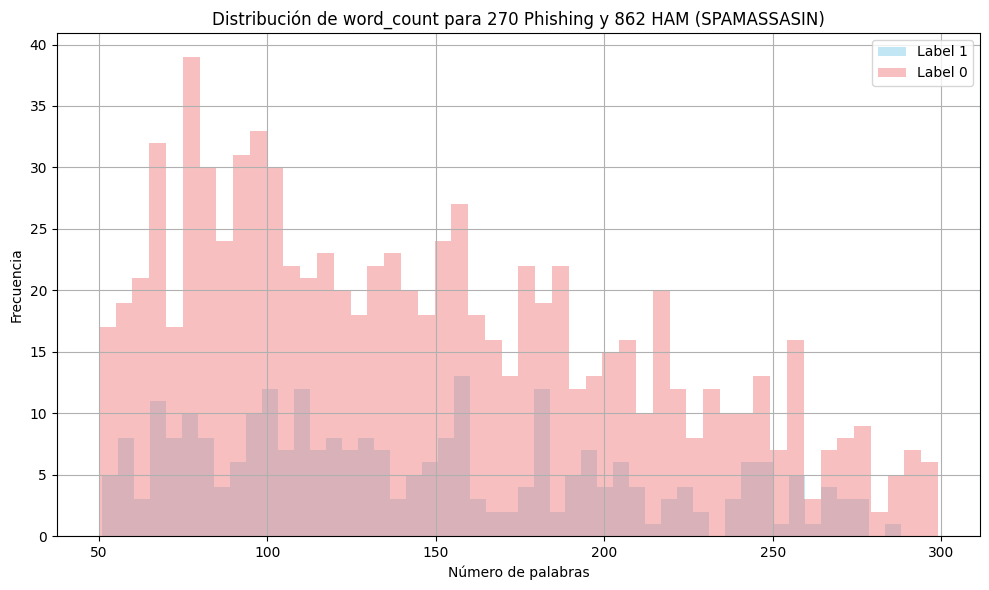

In [68]:
df_phishing_spamassasin = df_spamassasin_filtered[df_spamassasin_filtered['label'] == 1].sample(n=SAMPLE_SIZE_SPAMASSASIN_PHIS, random_state=SEED)
df_ham_spamassasin = df_spamassasin_filtered[df_spamassasin_filtered['label'] == 0].sample(n=SAMPLE_SIZE_SPAMASSASIN_HAM, random_state=SEED)

df_spamassasin = pd.concat([df_phishing_spamassasin, df_ham_spamassasin])

plot_word_count_histogram(df_spamassasin, f'Distribución de word_count para {SAMPLE_SIZE_SPAMASSASIN_PHIS} Phishing y {SAMPLE_SIZE_SPAMASSASIN_HAM} HAM (SPAMASSASIN)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [69]:
df_spamassasin = df_spamassasin.drop(columns=['word_count', 'language'])

print(f"{df_spamassasin.shape=}")


print("\nDistribución final de etiquetas:")
print(df_spamassasin['label'].value_counts())

df_spamassasin.shape=(1132, 3)

Distribución final de etiquetas:
label
0    862
1    270
Name: count, dtype: int64


## LING

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [28]:
df_ling = (
    pd.read_csv(DATA_LING, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

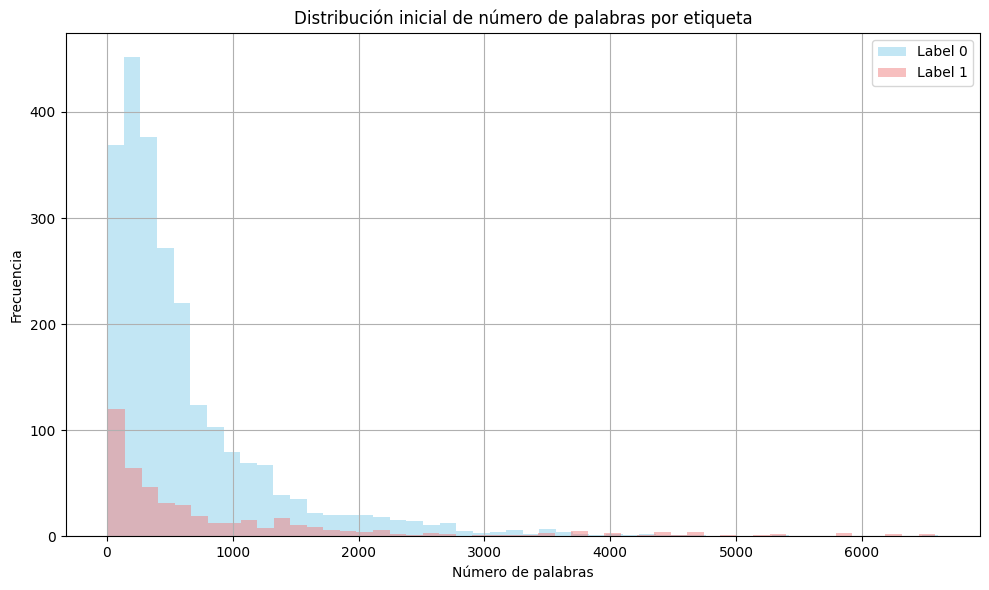

In [29]:
plot_word_count_histogram(df_ling,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


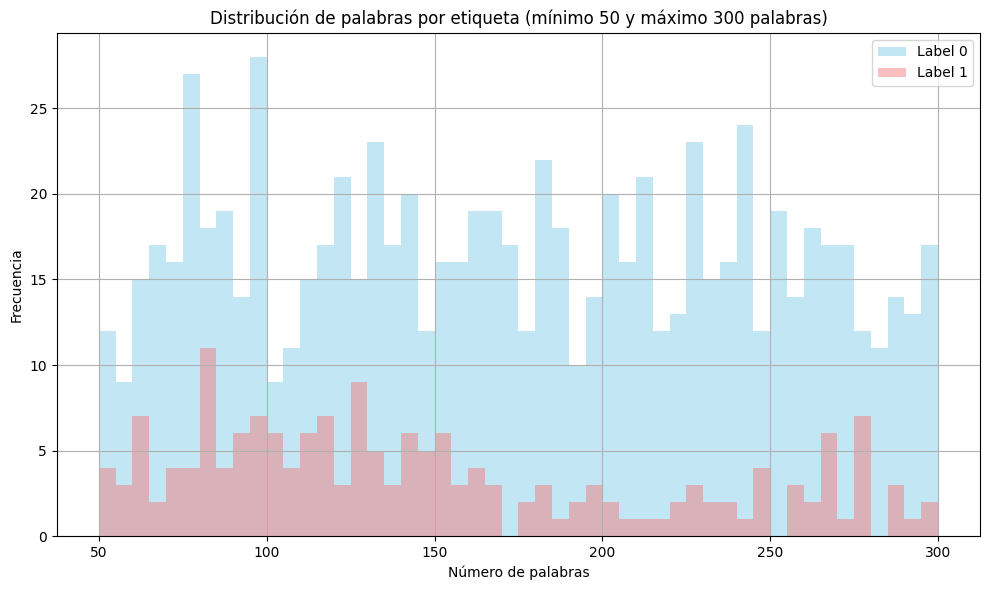

Número de instancias tras filtrado: 999


In [30]:
df_ling_filtered = df_ling[
    (df_ling['word_count'] <= MAX_WORDS) &
    (df_ling['word_count'] >= MIN_WORDS)
].copy()

df_ling_filtered['language'] = df_ling_filtered['body'].apply(detect_language)
df_ling_filtered = df_ling_filtered[df_ling_filtered['language'] == 'en']

plot_word_count_histogram(
    df_ling_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_ling_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


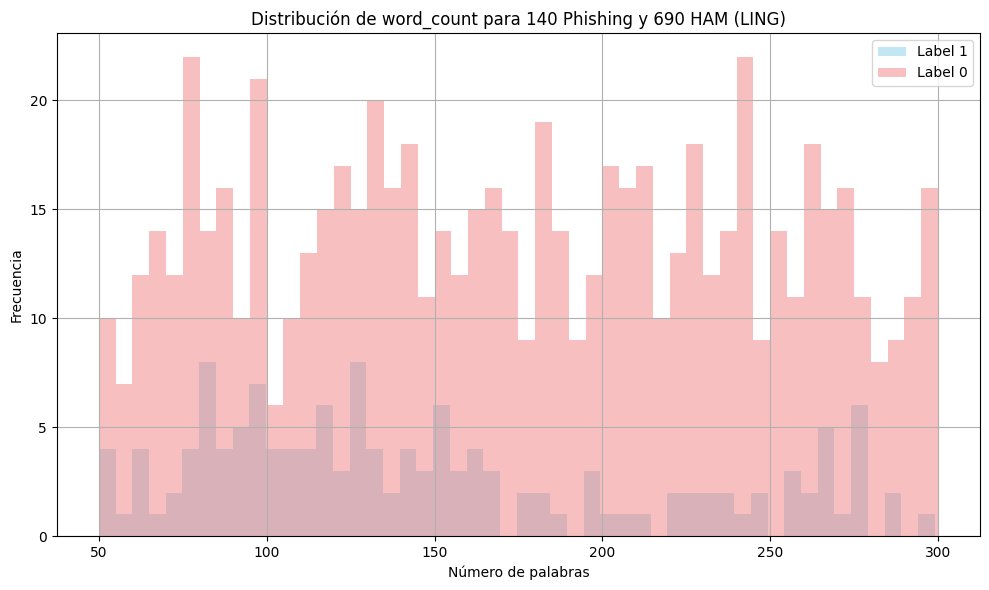

In [31]:
df_phishing_ling = df_ling_filtered[df_ling_filtered['label'] == 1].sample(n=SAMPLE_SIZE_LING_PHIS, random_state=SEED)
df_ham_ling = df_ling_filtered[df_ling_filtered['label'] == 0].sample(n=SAMPLE_SIZE_LING_HAM, random_state=SEED)

df_ling = pd.concat([df_phishing_ling, df_ham_ling])

plot_word_count_histogram(df_ling, f'Distribución de word_count para {SAMPLE_SIZE_LING_PHIS} Phishing y {SAMPLE_SIZE_LING_HAM} HAM (LING)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [32]:
df_ling = df_ling.drop(columns=['word_count', 'language'])

print(f"{df_ling.shape=}")


print("\nDistribución final de etiquetas:")
print(df_ling['label'].value_counts())

df_ling.shape=(830, 3)

Distribución final de etiquetas:
label
0    690
1    140
Name: count, dtype: int64


## NIGERIAN

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [33]:
df_nigerian = (
    pd.read_csv(DATA_NIGERIAN, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

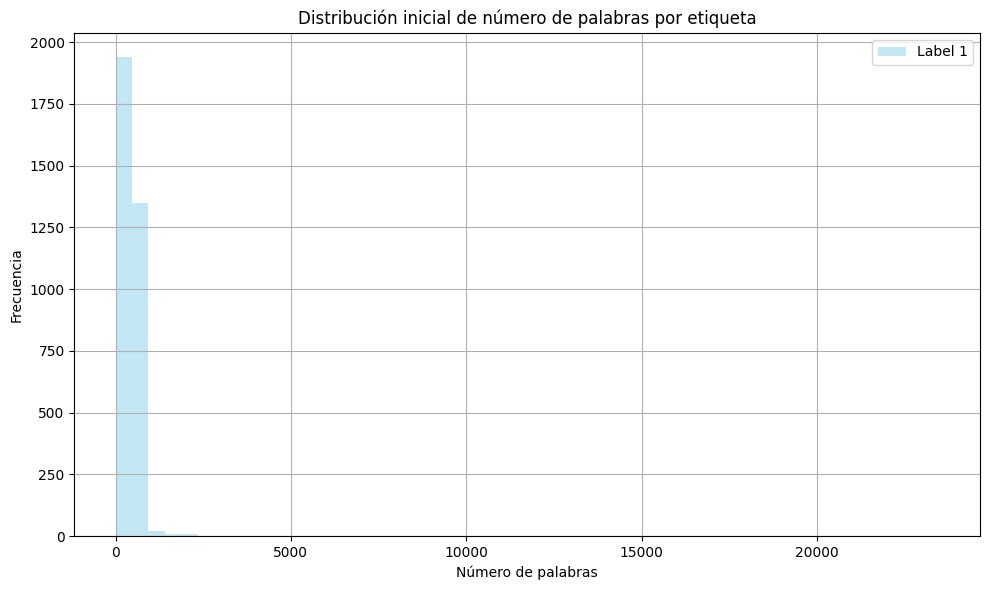

In [34]:
plot_word_count_histogram(df_nigerian,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


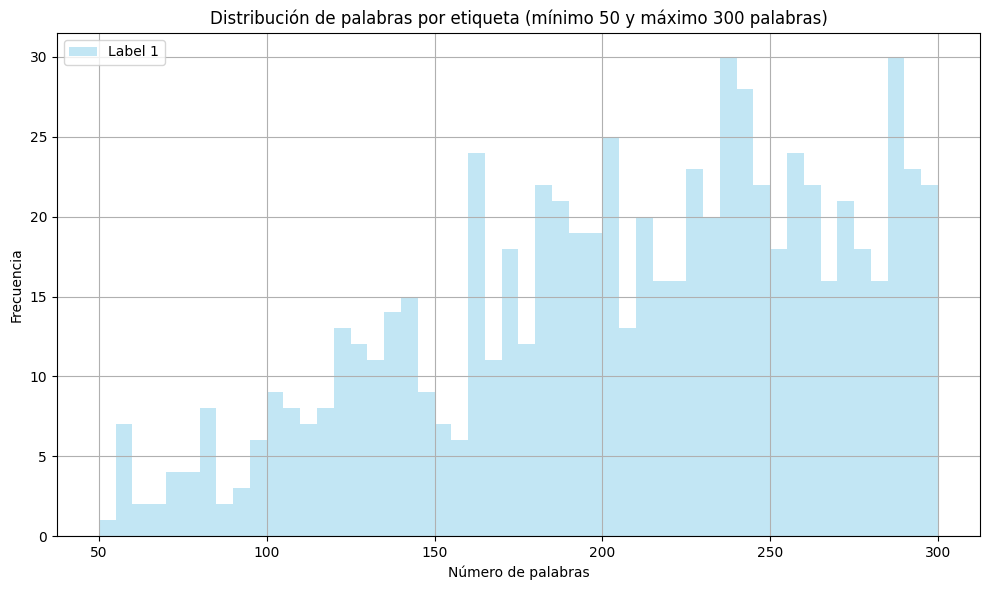

Número de instancias tras filtrado: 727


In [35]:
df_nigerian_filtered = df_nigerian[
    (df_nigerian['word_count'] <= MAX_WORDS) &
    (df_nigerian['word_count'] >= MIN_WORDS)
].copy()

df_nigerian_filtered['language'] = df_nigerian_filtered['body'].apply(detect_language)
df_nigerian_filtered = df_nigerian_filtered[df_nigerian_filtered['language'] == 'en']

plot_word_count_histogram(
    df_nigerian_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_nigerian_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


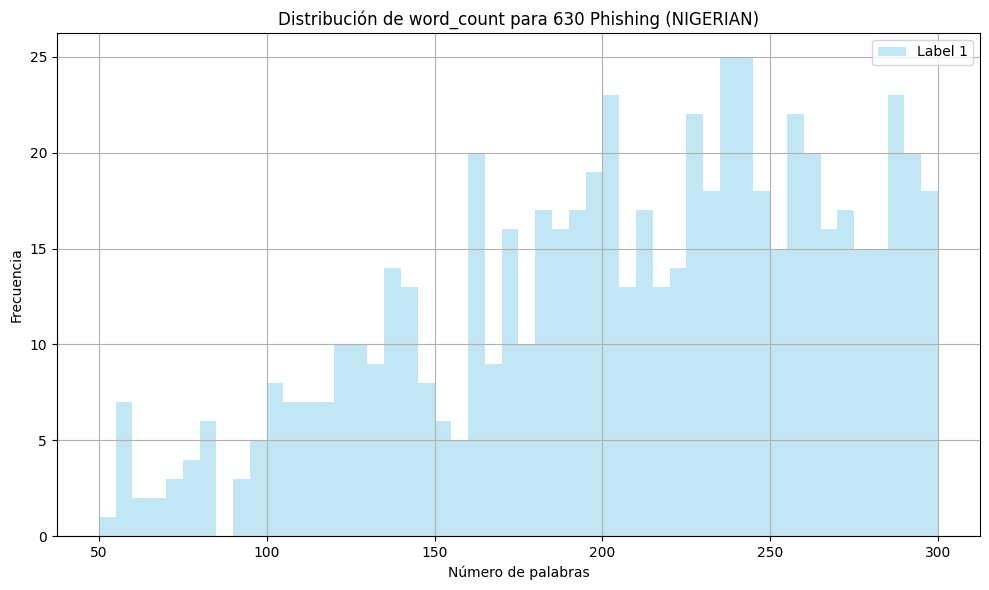

In [38]:
df_nigerian = df_nigerian_filtered.sample(n=SAMPLE_SIZE_NIGERIAN, random_state=SEED)

plot_word_count_histogram(df_nigerian, f'Distribución de word_count para {SAMPLE_SIZE_NIGERIAN} Phishing (NIGERIAN)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [39]:
df_nigerian = df_nigerian.drop(columns=['word_count', 'language'])

print(f"{df_nigerian.shape=}")


print("\nDistribución final de etiquetas:")
print(df_nigerian['label'].value_counts())

df_nigerian.shape=(630, 3)

Distribución final de etiquetas:
label
1    630
Name: count, dtype: int64


## NAZARIO

Esta celda carga el conjunto de datos desde el archivo CSV, seleccionando únicamente las columnas relevantes (`subject`, `body` y `label`).  
Después:

- Se asegura que el contenido de `body` sea tratado como texto.
- Se calcula una nueva columna llamada `word_count`, que representa la cantidad de palabras en el cuerpo de cada mensaje.

In [40]:
df_nazario = (
    pd.read_csv(DATA_NAZARIO, usecols=['subject', 'body', 'label'])
      .assign(body=lambda df: df['body'].astype(str),
              word_count=lambda df: df['body'].str.split().str.len())
)

Visualizamos la distribución inicial de número de palabras por etiqueta

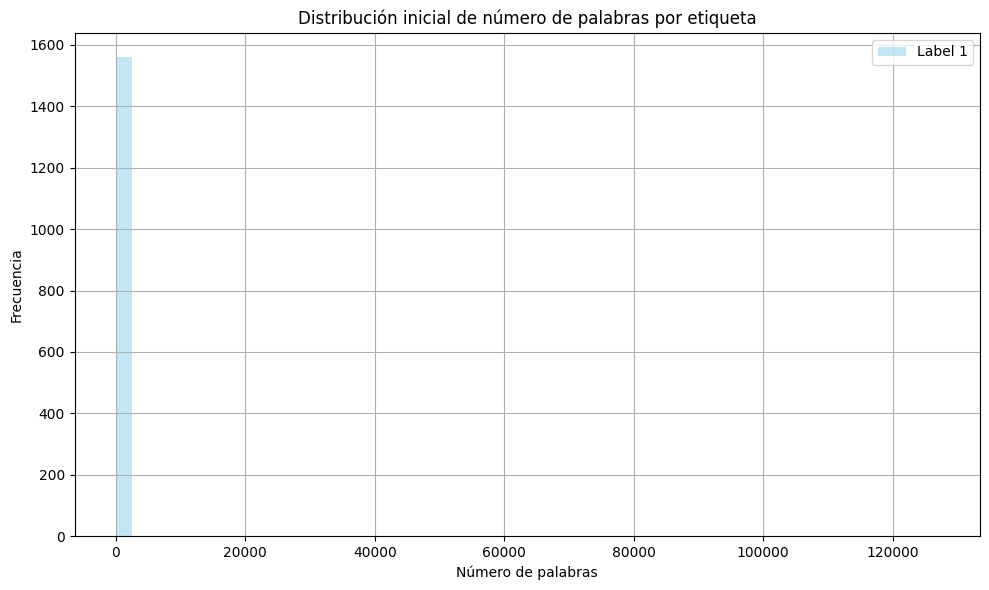

In [41]:
plot_word_count_histogram(df_nazario,
                          'Distribución inicial de número de palabras por etiqueta')

Filtramos los correos para excluir aquellos demasiado cortos, que carecen de una estructura suficiente para un *rephrasing* efectivo, así como los excesivamente largos, que pueden dificultar el procesamiento y reducir la coherencia del resultado.


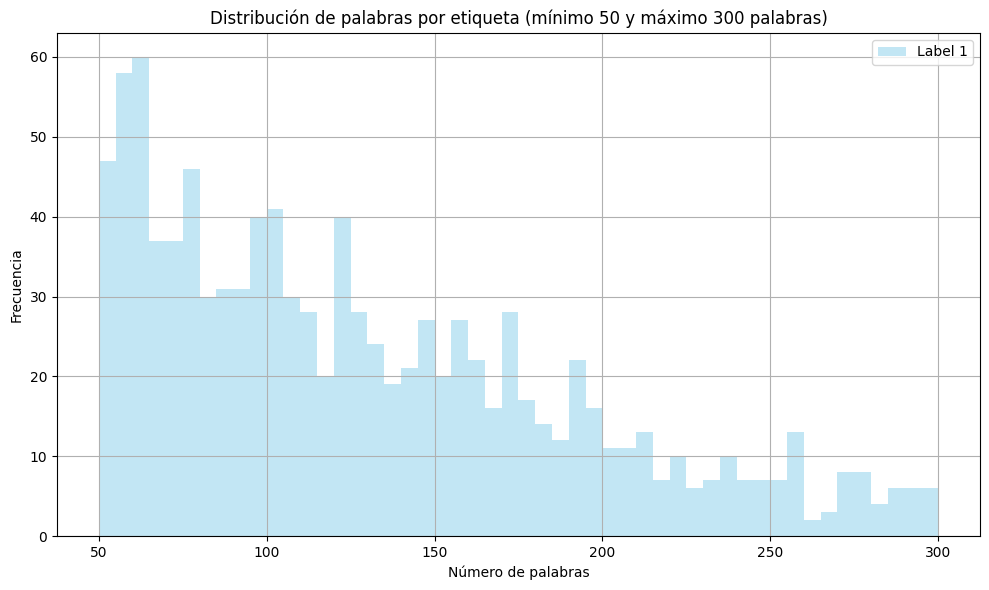

Número de instancias tras filtrado: 1041


In [42]:
df_nazario_filtered = df_nazario[
    (df_nazario['word_count'] <= MAX_WORDS) &
    (df_nazario['word_count'] >= MIN_WORDS)
].copy()

df_nazario_filtered['language'] = df_nazario_filtered['body'].apply(detect_language)
df_nazario_filtered = df_nazario_filtered[df_nazario_filtered['language'] == 'en']

plot_word_count_histogram(
    df_nazario_filtered,
    f'Distribución de palabras por etiqueta (mínimo {MIN_WORDS} y máximo {MAX_WORDS} palabras)'
)

print(f"Número de instancias tras filtrado: {df_nazario_filtered.shape[0]}")

Como solo queremos 1000 correos de cada tipo hacemos un muestreo aleatorio.


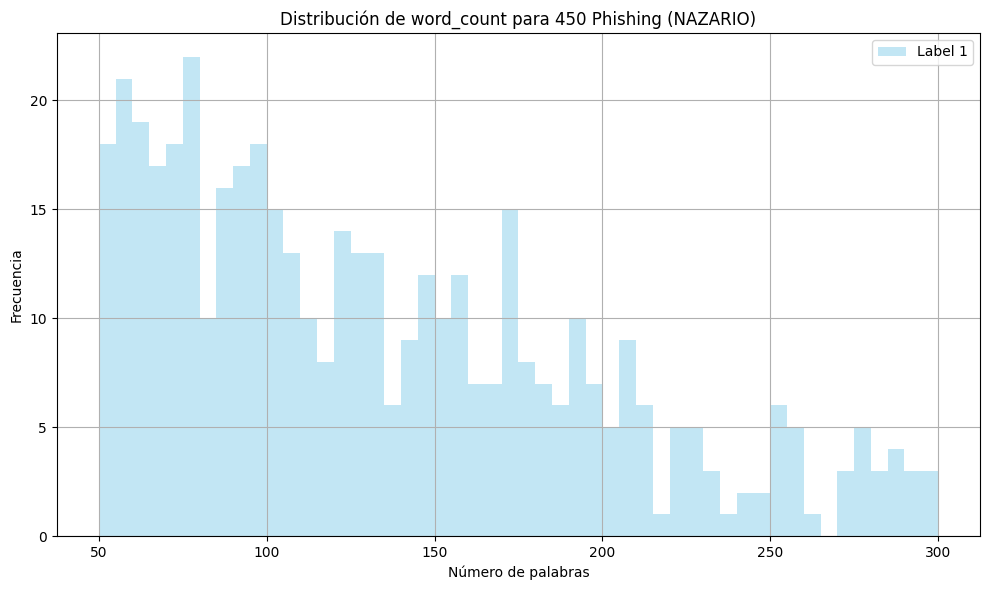

In [43]:
df_nazario = df_nazario_filtered.sample(n=SAMPLE_SIZE_NAZARIO, random_state=SEED)

plot_word_count_histogram(df_nazario, f'Distribución de word_count para {SAMPLE_SIZE_NAZARIO} Phishing (NAZARIO)')

Eliminamos la columna `word_count` y verificamos que el DataFrame resultante contiene el número esperado de instancias y columnas.




In [44]:
df_nazario = df_nazario.drop(columns=['word_count', 'language'])

print(f"{df_nazario.shape=}")


print("\nDistribución final de etiquetas:")
print(df_nazario['label'].value_counts())

df_nazario.shape=(450, 3)

Distribución final de etiquetas:
label
1    450
Name: count, dtype: int64


# Concatenación y Unificación de Datasets

Añadimos una columna `source` para saber de qué dataset proviene cada instancia.

In [91]:
df_trec['source'] = 'TREC'
df_ceas['source'] = 'CEAS'
df_enron['source'] = 'ENRON'
df_spamassasin['source'] = 'SPAMASSASIN'
df_ling['source'] = 'LING'
df_nigerian['source'] = 'NIGERIAN'
df_nazario['source'] = 'NAZARIO'

Y ahora unificamos todos los datasets en un único dataset.

In [92]:
df_all = pd.concat([
    df_trec,
    df_ceas,
    df_enron,
    df_spamassasin,
    df_ling,
    df_nigerian,
    df_nazario
], ignore_index=True)

Verificamos que tengamos el dataset como hemos especificado inicialmente

In [93]:
print(f"{df_all['source'].value_counts()}\n")
print(f"{df_all['label'].value_counts()}\n")

print(f"{df_all.shape=}")
print(f"{df_all.columns=}")

source
TREC           3474
CEAS           1742
ENRON          1742
SPAMASSASIN    1132
LING            830
NIGERIAN        630
NAZARIO         450
Name: count, dtype: int64

label
1    5000
0    5000
Name: count, dtype: int64

df_all.shape=(10000, 4)
df_all.columns=Index(['label', 'subject', 'body', 'source'], dtype='object')


Procedemos a guardarlo como csv

In [94]:
df_all.to_csv(MERGED_DATASET, index=False)